In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 100
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
import torch
import torch.nn as nn
class RealNVPBlock(nn.Module):
    def __init__(self, in_features, hidden_features):
        super(RealNVPBlock, self).__init__()
        self.net_s = nn.Sequential(
            nn.Linear(in_features // 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features*2),
            nn.ReLU(),
            nn.Linear(hidden_features*2, hidden_features*2),
            nn.ReLU(),
            nn.Linear(hidden_features*2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, in_features // 2),
            nn.ReLU()
        )
        self.net_t = nn.Sequential(
            nn.Linear(in_features // 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features*2),
            nn.ReLU(),
            nn.Linear(hidden_features*2, hidden_features*2),
            nn.ReLU(),
            nn.Linear(hidden_features*2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, in_features // 2),
            nn.ReLU()
        )
    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        x_a = y_a
        s = self.net_s(y_a)
        t = self.net_t(y_a)
        x_b = (y_b - t)*torch.exp(-s)
        x = torch.cat([x_a, x_b], dim=1)
        return x
    def forward(self,x):
        x_a, x_b = x.chunk(2,dim=1)
        y_a = x_a
        s = self.net_s(x_a)
        t = self.net_t(x_a)
        y_b = x_b * torch.exp(s) + t
        log_det_Jac = -s.sum(dim=1)
        y = torch.cat([y_a, y_b], dim=1)
        return y,log_det_Jac
class RealNVP(nn.Module):
    def __init__(self, num_blocks, in_features, hidden_features):
        super(RealNVP, self).__init__()
        self.in_features=  in_features
        self.blocks = nn.ModuleList([RealNVPBlock(self.in_features, hidden_features) for _ in range(num_blocks)])
        self.blocks = self.blocks.to(device)
        self.prior =  distributions.MultivariateNormal(torch.zeros(self.in_features), torch.eye(self.in_features))
    def forward(self, x):
        # pdb.set_trace()
        sum_log_det_Jac= x.new_zeros(x.shape[0]).to(device)
        for block in self.blocks:
            x,log_det_Jac = block.forward(x)
            sum_log_det_Jac +=log_det_Jac
            x = torch.flip(x,dims=(1,))
        y = x
        return y,sum_log_det_Jac
    def backward(self,y):
        for block in reversed(self.blocks):
            y = block.backward(y)
            y = torch.flip(y,dims=(1,))
        x = y
        return x
    def log_prob(self,x):
        y, logp = self.forward(x)
        # pdb.set_trace()
        y = y.to('cpu')
        p_z = self.prior.log_prob(y)
        p_z = p_z.to(device)
        return (p_z+logp)
    def sample(self, batchSize):
        y = self.prior.sample((batchSize,1))
        if y.dim()>2:
          y = torch.squeeze(y)
        y=y.to('cpu')
        logp = self.prior.log_prob(y)
        y = y.to(device)
        x = self.backward(y)
        return x

In [89]:
num_blocks = 6
in_features = 28 * 28
hidden_features = 512
batch_size = 512
learning_rate = 0.001
epochs = 100
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((-.5,), (-.5,))])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a DataLoader to batch and shuffle the data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [12]:
import pdb

In [90]:
real_nvp_model = RealNVP(num_blocks, in_features, hidden_features).to(device)
train_loss =[]
test_loss = []
result_images=[]

In [93]:
optimizer = torch.optim.Adam(real_nvp_model.parameters(),lr=learning_rate)
for t in tqdm(range(epochs)):
  tr_loss = 0
  for batch in train_loader:
    # pdb.set_trace()
    images,_ = batch
    images = images.view(-1, in_features).to(device)
    loss = -(real_nvp_model.log_prob(images)).mean()
    tr_loss +=loss.item()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
  train_loss.append(tr_loss/len(train_loader))
  with torch.no_grad():
    te_loss = 0
    for batch in test_loader:
      images,_=batch
      images.view(-1,in_features)
      images = images.view(-1, in_features).to(device)
      te_loss +=-(real_nvp_model.log_prob(images)).mean().item()
    test_loss.append(te_loss/len(test_loader))
    x = real_nvp_model.sample(16).cpu().detach().view(-1,28,28).numpy()
    result_images.append(x)
  print('iter %s:' % t, 'loss = %.3f' % (tr_loss/len(train_loader)), 'validation loss = %.3f' % (te_loss/len(test_loader)))

  1%|          | 1/100 [00:34<57:40, 34.96s/it]

iter 0: loss = 1457550.909 validation loss = 777.408


  2%|▏         | 2/100 [01:08<56:07, 34.37s/it]

iter 1: loss = 772.926 validation loss = 770.132


  3%|▎         | 3/100 [01:43<55:51, 34.55s/it]

iter 2: loss = 768.211 validation loss = 767.097


  4%|▍         | 4/100 [02:17<54:58, 34.36s/it]

iter 3: loss = 765.290 validation loss = 763.945


  5%|▌         | 5/100 [02:52<54:54, 34.68s/it]

iter 4: loss = 762.694 validation loss = 762.820


  6%|▌         | 6/100 [03:27<54:21, 34.70s/it]

iter 5: loss = 760.919 validation loss = 761.690


  7%|▋         | 7/100 [04:02<53:50, 34.73s/it]

iter 6: loss = 758.845 validation loss = 757.793


  8%|▊         | 8/100 [04:37<53:09, 34.67s/it]

iter 7: loss = 756.957 validation loss = 755.935


  9%|▉         | 9/100 [05:11<52:31, 34.63s/it]

iter 8: loss = 755.780 validation loss = 754.553


 10%|█         | 10/100 [05:45<51:42, 34.47s/it]

iter 9: loss = 754.233 validation loss = 753.190


 11%|█         | 11/100 [06:20<51:14, 34.55s/it]

iter 10: loss = 752.826 validation loss = 752.051


 12%|█▏        | 12/100 [06:55<50:49, 34.65s/it]

iter 11: loss = 752.069 validation loss = 753.048


 13%|█▎        | 13/100 [07:29<49:59, 34.48s/it]

iter 12: loss = 750.706 validation loss = 750.189


 14%|█▍        | 14/100 [08:03<49:23, 34.45s/it]

iter 13: loss = 753.110 validation loss = 749.665


 15%|█▌        | 15/100 [08:37<48:37, 34.32s/it]

iter 14: loss = 748.668 validation loss = 748.927


 16%|█▌        | 16/100 [09:11<47:44, 34.10s/it]

iter 15: loss = 748.217 validation loss = 747.816


 17%|█▋        | 17/100 [09:46<47:25, 34.29s/it]

iter 16: loss = 747.218 validation loss = 747.088


 18%|█▊        | 18/100 [10:19<46:28, 34.00s/it]

iter 17: loss = 747.732 validation loss = 751.688


 19%|█▉        | 19/100 [10:53<46:02, 34.10s/it]

iter 18: loss = 746.543 validation loss = 745.377


 20%|██        | 20/100 [11:27<45:14, 33.93s/it]

iter 19: loss = 745.286 validation loss = 744.938


 21%|██        | 21/100 [12:01<44:57, 34.14s/it]

iter 20: loss = 745.049 validation loss = 745.807


 22%|██▏       | 22/100 [12:35<44:03, 33.89s/it]

iter 21: loss = 744.471 validation loss = 743.809


 23%|██▎       | 23/100 [13:10<43:54, 34.22s/it]

iter 22: loss = 743.915 validation loss = 743.267


 24%|██▍       | 24/100 [13:43<43:03, 33.99s/it]

iter 23: loss = 745.641 validation loss = 743.512


 25%|██▌       | 25/100 [14:18<42:42, 34.17s/it]

iter 24: loss = 742.912 validation loss = 744.834


 26%|██▌       | 26/100 [14:51<41:49, 33.91s/it]

iter 25: loss = 742.916 validation loss = 741.905


 27%|██▋       | 27/100 [15:25<41:18, 33.95s/it]

iter 26: loss = 742.226 validation loss = 741.754


 28%|██▊       | 28/100 [15:59<40:33, 33.80s/it]

iter 27: loss = 743.083 validation loss = 743.566


 29%|██▉       | 29/100 [16:33<40:14, 34.01s/it]

iter 28: loss = 741.611 validation loss = 740.994


 30%|███       | 30/100 [17:06<39:15, 33.65s/it]

iter 29: loss = 741.097 validation loss = 740.904


 31%|███       | 31/100 [17:40<38:55, 33.84s/it]

iter 30: loss = 741.743 validation loss = 740.365


 32%|███▏      | 32/100 [18:14<38:18, 33.80s/it]

iter 31: loss = 740.254 validation loss = 741.026


 33%|███▎      | 33/100 [18:48<37:54, 33.95s/it]

iter 32: loss = 742.501 validation loss = 740.825


 34%|███▍      | 34/100 [19:22<37:14, 33.86s/it]

iter 33: loss = 740.019 validation loss = 739.709


 35%|███▌      | 35/100 [19:56<36:44, 33.92s/it]

iter 34: loss = 740.998 validation loss = 739.612


 36%|███▌      | 36/100 [20:30<36:08, 33.88s/it]

iter 35: loss = 739.253 validation loss = 739.629


 37%|███▋      | 37/100 [21:03<35:23, 33.70s/it]

iter 36: loss = 739.696 validation loss = 739.013


 38%|███▊      | 38/100 [21:37<35:02, 33.91s/it]

iter 37: loss = 738.995 validation loss = 739.202


 39%|███▉      | 39/100 [22:11<34:15, 33.69s/it]

iter 38: loss = 738.577 validation loss = 738.684


 40%|████      | 40/100 [22:45<33:52, 33.87s/it]

iter 39: loss = 747.937 validation loss = 742.728


 41%|████      | 41/100 [23:18<33:07, 33.68s/it]

iter 40: loss = 740.475 validation loss = 739.404


 42%|████▏     | 42/100 [23:52<32:40, 33.81s/it]

iter 41: loss = 739.056 validation loss = 739.133


 43%|████▎     | 43/100 [24:25<31:48, 33.49s/it]

iter 42: loss = 738.627 validation loss = 738.973


 44%|████▍     | 44/100 [24:59<31:19, 33.56s/it]

iter 43: loss = 738.476 validation loss = 738.787


 45%|████▌     | 45/100 [25:31<30:32, 33.32s/it]

iter 44: loss = 738.152 validation loss = 738.386


 46%|████▌     | 46/100 [26:04<29:54, 33.23s/it]

iter 45: loss = 738.380 validation loss = 739.202


 47%|████▋     | 47/100 [26:38<29:33, 33.46s/it]

iter 46: loss = 737.873 validation loss = 737.396


 48%|████▊     | 48/100 [27:12<28:54, 33.36s/it]

iter 47: loss = 737.533 validation loss = 737.865


 49%|████▉     | 49/100 [27:45<28:28, 33.49s/it]

iter 48: loss = 737.298 validation loss = 739.074


 50%|█████     | 50/100 [28:19<27:49, 33.39s/it]

iter 49: loss = 738.779 validation loss = 736.849


 51%|█████     | 51/100 [28:52<27:21, 33.49s/it]

iter 50: loss = 736.629 validation loss = 736.721


 52%|█████▏    | 52/100 [29:25<26:42, 33.38s/it]

iter 51: loss = 737.094 validation loss = 738.092


 53%|█████▎    | 53/100 [29:59<26:18, 33.59s/it]

iter 52: loss = 737.168 validation loss = 736.127


 54%|█████▍    | 54/100 [30:33<25:39, 33.47s/it]

iter 53: loss = 736.267 validation loss = 736.209


 55%|█████▌    | 55/100 [31:06<25:04, 33.44s/it]

iter 54: loss = 740.558 validation loss = 738.542


 56%|█████▌    | 56/100 [31:40<24:43, 33.71s/it]

iter 55: loss = 736.669 validation loss = 735.936


 57%|█████▋    | 57/100 [32:14<24:06, 33.65s/it]

iter 56: loss = 735.950 validation loss = 736.183


 58%|█████▊    | 58/100 [32:48<23:37, 33.75s/it]

iter 57: loss = 735.893 validation loss = 736.938


 59%|█████▉    | 59/100 [33:21<22:55, 33.56s/it]

iter 58: loss = 736.019 validation loss = 735.590


 60%|██████    | 60/100 [33:55<22:32, 33.82s/it]

iter 59: loss = 735.911 validation loss = 735.970


 61%|██████    | 61/100 [34:28<21:47, 33.53s/it]

iter 60: loss = 740.217 validation loss = 735.932


 62%|██████▏   | 62/100 [35:02<21:18, 33.63s/it]

iter 61: loss = 735.515 validation loss = 736.037


 63%|██████▎   | 63/100 [35:35<20:33, 33.33s/it]

iter 62: loss = 735.371 validation loss = 735.411


 64%|██████▍   | 64/100 [36:08<20:04, 33.46s/it]

iter 63: loss = 738.602 validation loss = 738.020


 65%|██████▌   | 65/100 [36:42<19:33, 33.53s/it]

iter 64: loss = 735.651 validation loss = 735.031


 66%|██████▌   | 66/100 [37:15<18:53, 33.33s/it]

iter 65: loss = 734.832 validation loss = 734.761


 67%|██████▋   | 67/100 [37:49<18:24, 33.46s/it]

iter 66: loss = 735.684 validation loss = 734.901


 68%|██████▊   | 68/100 [38:22<17:45, 33.31s/it]

iter 67: loss = 734.504 validation loss = 734.460


 69%|██████▉   | 69/100 [38:56<17:19, 33.53s/it]

iter 68: loss = 734.528 validation loss = 734.284


 70%|███████   | 70/100 [39:29<16:43, 33.45s/it]

iter 69: loss = 734.875 validation loss = 734.771


 71%|███████   | 71/100 [40:03<16:13, 33.58s/it]

iter 70: loss = 734.193 validation loss = 734.682


 72%|███████▏  | 72/100 [40:36<15:38, 33.51s/it]

iter 71: loss = 734.692 validation loss = 734.572


 73%|███████▎  | 73/100 [41:10<15:05, 33.52s/it]

iter 72: loss = 734.050 validation loss = 734.000


 74%|███████▍  | 74/100 [41:43<14:31, 33.52s/it]

iter 73: loss = 734.935 validation loss = 735.771


 75%|███████▌  | 75/100 [42:16<13:53, 33.35s/it]

iter 74: loss = 734.096 validation loss = 733.701


 76%|███████▌  | 76/100 [42:51<13:27, 33.66s/it]

iter 75: loss = 734.987 validation loss = 750.528


 77%|███████▋  | 77/100 [43:24<12:48, 33.42s/it]

iter 76: loss = 736.408 validation loss = 733.906


 78%|███████▊  | 78/100 [43:58<12:19, 33.63s/it]

iter 77: loss = 733.568 validation loss = 733.489


 79%|███████▉  | 79/100 [44:31<11:41, 33.40s/it]

iter 78: loss = 733.516 validation loss = 733.674


 80%|████████  | 80/100 [45:04<11:07, 33.38s/it]

iter 79: loss = 733.463 validation loss = 733.419


 81%|████████  | 81/100 [45:37<10:33, 33.33s/it]

iter 80: loss = 735.400 validation loss = 736.307


 82%|████████▏ | 82/100 [46:10<10:00, 33.34s/it]

iter 81: loss = 733.670 validation loss = 733.320


 83%|████████▎ | 83/100 [46:44<09:27, 33.41s/it]

iter 82: loss = 733.040 validation loss = 733.531


 84%|████████▍ | 84/100 [47:17<08:51, 33.21s/it]

iter 83: loss = 733.931 validation loss = 736.189


 85%|████████▌ | 85/100 [47:51<08:20, 33.38s/it]

iter 84: loss = 733.201 validation loss = 732.767


 86%|████████▌ | 86/100 [48:23<07:44, 33.16s/it]

iter 85: loss = 733.538 validation loss = 739.731


 87%|████████▋ | 87/100 [48:57<07:13, 33.31s/it]

iter 86: loss = 735.277 validation loss = 732.807


 88%|████████▊ | 88/100 [49:30<06:38, 33.23s/it]

iter 87: loss = 732.682 validation loss = 732.947


 89%|████████▉ | 89/100 [50:03<06:03, 33.06s/it]

iter 88: loss = 732.669 validation loss = 732.761


 90%|█████████ | 90/100 [50:36<05:30, 33.10s/it]

iter 89: loss = 733.974 validation loss = 739.772


 91%|█████████ | 91/100 [51:09<04:58, 33.15s/it]

iter 90: loss = 736.174 validation loss = 733.071


 92%|█████████▏| 92/100 [51:43<04:28, 33.54s/it]

iter 91: loss = 732.605 validation loss = 732.467


 93%|█████████▎| 93/100 [52:17<03:53, 33.39s/it]

iter 92: loss = 732.430 validation loss = 732.628


 94%|█████████▍| 94/100 [52:50<03:20, 33.49s/it]

iter 93: loss = 732.622 validation loss = 732.164


 95%|█████████▌| 95/100 [53:22<02:45, 33.08s/it]

iter 94: loss = 732.278 validation loss = 732.844


 96%|█████████▌| 96/100 [53:55<02:11, 32.92s/it]

iter 95: loss = 732.818 validation loss = 732.368


 97%|█████████▋| 97/100 [54:29<01:40, 33.35s/it]

iter 96: loss = 732.084 validation loss = 732.067


 98%|█████████▊| 98/100 [55:02<01:06, 33.10s/it]

iter 97: loss = 735.928 validation loss = 733.868


 99%|█████████▉| 99/100 [55:36<00:33, 33.50s/it]

iter 98: loss = 732.549 validation loss = 732.179


100%|██████████| 100/100 [56:09<00:00, 33.70s/it]

iter 99: loss = 732.015 validation loss = 731.983


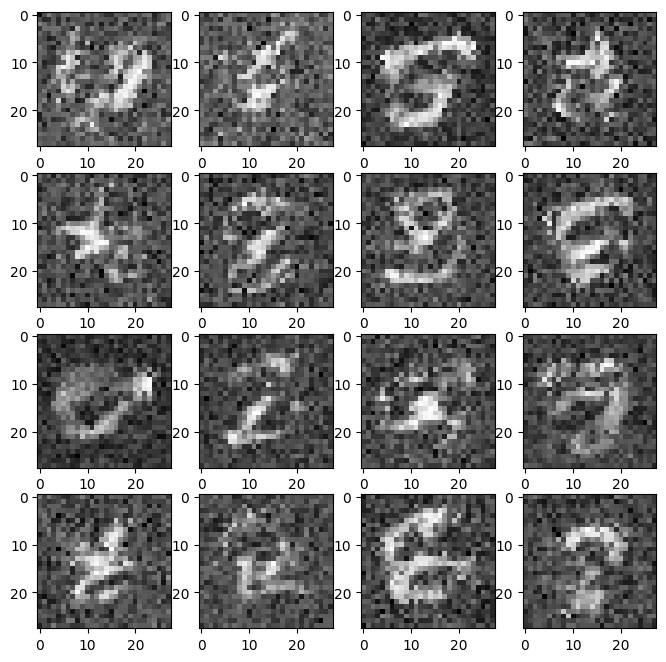

In [95]:
fig,axes = plt.subplots(4,4,figsize=(8,8))
for j,img in enumerate(result_images):
  for i,ax in enumerate(axes.flatten()):
    ax.imshow(img[i],cmap='Greys')

  fig.savefig(f'/content/data/png/{j}.png')

In [96]:
import os
import imageio

png_dir = '/content/data/png'
images = []
files = [f'/content/data/png/{i}.png' for i in range(epochs)]
for file_name in files:
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('/content/data/png/movie.gif', images)

<ipython-input-96-b39287929b8e>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-96-b39287929b8e>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


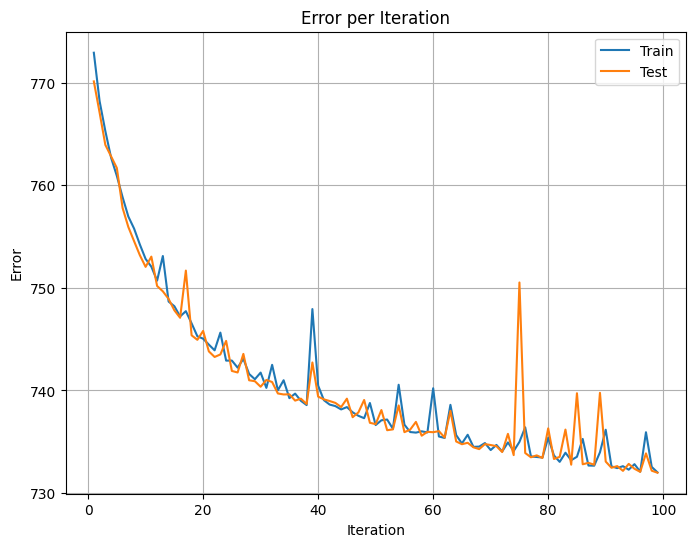

In [102]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,100),train_loss[5:],label='Train')
plt.plot(np.arange(1,100),test_loss[5:],label='Test')
plt.title('Error per Iteration')
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.grid()
plt.legend()
plt.show()